# Alarm data - *Descriptive Statistics*

## Input

#### Imports

In [3]:
import pandas as pd
import numpy as np
import collections
import datetime
from dateutil.relativedelta import relativedelta
from calendar import monthrange
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use = 'default' 

#### Data

In [4]:
# Read data
files = ["../Data_Acetate/acetateAlarms.csv","../Data_Acetate/acetateAlarmsTr.csv"]
dfs = [pd.read_csv(f,encoding="utf-8-sig") for f in files]
dfs[0]['System'] = "Acetate"
dfs[1]['System'] = "Tracing"
df = pd.concat(dfs)

# Transform data
if 'State' in df.columns:
    df = df[df['State']==1]                                         
    del df['State']
if 'Timestamp' in df.columns:    
    df['Date'] = df['Timestamp'].map(lambda x: x.split(' ')[0])     
    df['Time'] = df['Timestamp'].map(lambda x: x.split(' ')[1])
    del df['Timestamp']
    
# Filter data
df = df[df['Class']=='Error']
del df['Class']
df.sort_values(by=['Date','Time'],inplace=True)

# Split data
gr = df.groupby(df['Date'].map(lambda x: x.split('-')[0]+'-'+x.split('-')[1]))
dfs = {x:gr.get_group(x).copy() for x in gr.groups}
dfs = collections.OrderedDict(sorted(dfs.items(), key=lambda x: x[0]))

#dfs[list(dfs.keys())[0]].head(3)

## Selected Input

In [5]:
# Data frame
def _SortOut(df_x,column,items):
    df_y = df_x[df_x[column].map(lambda x: x in items)].copy()
    #df_y.drop_duplicates(inplace=True)
    return df_y

def _SelectItems(dfs_x,column,items):
    dfs_y = {key: _SortOut(dfs_x[key],column,items) for key in dfs_x}
    dfs_y = collections.OrderedDict(sorted(dfs_y.items(), key=lambda x: x[0]))   
    return dfs_y

def _SelectMonths(dfs_x,months):
    dfs_y = dict()
    for key in dfs_x:
        if key in months:
            dfs_y[key] = dfs_x[key].copy()
    dfs_y = collections.OrderedDict(sorted(dfs_y.items(), key=lambda x: x[0]))   
    return dfs_y

def Data(dfs_x,months,ids,groups):
    dfs_y = dfs_x.copy() 
    if months:   dfs_y = _SelectMonths(dfs_y,months)  
    if ids:      dfs_y = _SelectItems(dfs_y,'Id',ids)   
    elif groups: dfs_y = _SelectItems(dfs_y,'Group',groups)
    return dfs_y

def Print(months,ids,groups):
    txt_m = txt_i = txt_g = '/' 
    if months: txt_m = ', '.join(months) if len(months)>1 else months[0]
    if ids:    txt_i = ', '.join(ids) if len(ids)>1 else ids[0]
    if groups: txt_g = ', '.join(groups) if len(groups)>1 else groups[0]    
    print(" Months: {}".format(txt_m))
    print(" ID's: {}".format(txt_i))
    print("{}Groups: {}{}".format('(' if (Ids and Groups) else ' ', txt_g, ')' if (Ids and Groups) else ''))
    return

# Cross table
def _MonthRange(df_x,month):
    m = [int(x) for x in month.split('-')]
    _,r = monthrange(m[0],m[1])
    r = [(month + '-' + str(x).zfill(2)) for x in range(1,r+1)]
    for x in r:
        if x not in df_x.index:
            df_x.loc[x] = 0
    return df_x

def _CrossTab(df_x,key,col='count',srt=None,mrg=False):
    ct_x = pd.crosstab(index=df_x[key],columns=(df_x[col] if col!='count' else col),margins=mrg)
    if srt: ct_x.sort_values(by=srt,ascending=False,inplace=True)
    return ct_x

def Data_CrossTable(dfs_x,col='count',srt=None):
    cts_x = {x:_CrossTab(dfs_x[x],'Date',col=col,srt=srt) for x in dfs_x.keys()}
    cts_x = {x:_MonthRange(cts_x[x],x) for x in dfs_x.keys()}
    for x in dfs_x:
        cts_x[x].sort_index(inplace=True)
    cts_x = collections.OrderedDict(sorted(cts_x.items(), key=lambda x: x[0]))       
    return cts_x

In [6]:
Months = Ids = Groups = None
#Months = ['2016-01','2016-02','2015-11']
#Ids = ['TT-300-6-004','XS-TR32-LPM-01-LDT']   # ids OR groups!
#Groups = ['T250-4']

In [7]:
dfs_select = Data(dfs,Months,Ids,Groups)
col = 'Id' if Ids else ('Group' if Groups else None)
if col: cts_select = Data_CrossTable(dfs_select,col=col)
else:   cts_select = Data_CrossTable(dfs_select)

## Measures of Center

In [10]:
# Plot
def PlotMoC(dfs_x,sz=(12,4),st=False):
    rmax = 0
    for key in dfs_x:
        max_next = cts_select[key].max().values[0]
        if max_next > rmax:
            rmax = max_next
            
    for i,key in enumerate(dfs_x):
        print('{}\n{}'.format(key,'-'*len(key)))
        print('Mean:   {:.2f}'.format(cts_select[key].mean().values[0]))
        print('Median: {:.2f}'.format(cts_select[key].median().values[0]))
         
        ax = plt.subplot(1,1,1) 
        
        text_id = text_gr = ''
        if Ids: text_id = ", ID's: {}".format(', '.join(Ids) if len(Ids)>1 else Ids[0])
        elif Groups: text_gr = ", groups: {}".format(', '.join(Groups) if len(Groups)>1 else Groups[0])
        
        dfs_x[key].plot.bar(ax=ax,title="Alarms per day ({}){}{}".format(key,text_id,text_gr))     
        ax.set_xticklabels([int(x.split('-')[-1]) for x in dfs_x[key].index])
        ax.legend().set_visible(False)
        plt.xticks(rotation='horizontal')
        plt.yticks(range(0,rmax+1,10))
        ax.axhline(dfs_x[key].mean().values[0],color='r')
        ax.axhline(dfs_x[key].median().values[0],color='c')
       
        plt.ylabel('# Alarms')    
        plt.show()
    return

2015-11
-------
Mean:   8.67
Median: 1.00


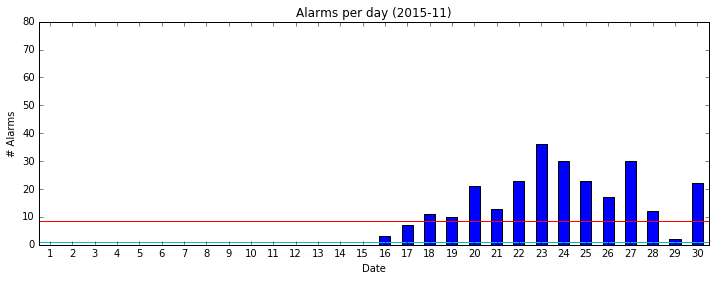

2015-12
-------
Mean:   22.71
Median: 20.00


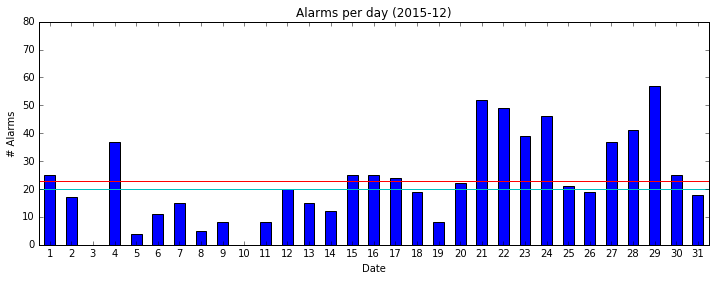

2016-01
-------
Mean:   16.77
Median: 9.00


2016-02
-------
Mean:   11.14
Median: 9.00


2016-03
-------
Mean:   5.35
Median: 0.00


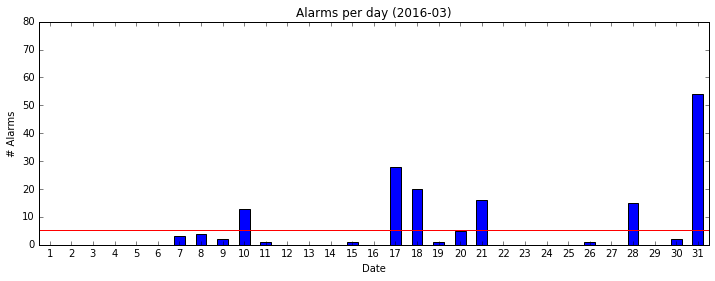

2016-04
-------
Mean:   3.37
Median: 0.00


In [11]:
PlotMoC(cts_select)

## Measures of Spread

In [32]:
# Plot
def PlotMoS(dfs_x,sz=(16,4),st=False):
    rmax = 0
    for key in dfs_x:
        max_next = cts_select[key].max().values[0]
        if max_next > rmax:
            rmax = max_next
            
    for i,key in enumerate(dfs_x):
        print('{}\n{}'.format(key,'-'*len(key)))
        print('Range:  {:.2f}'.format(cts_select[key].max().values[0]-cts_select[key].min().values[0]))
        print('IQR:    {:.2f}'.format(cts_select[key].quantile(0.75).values[0]-cts_select[key].quantile(0.25).values[0]))
        print('var:    {:.2f}'.format(cts_select[key].var().values[0]))
        print('std:    {:.2f}'.format(cts_select[key].std().values[0]))
        
        plt.figure(i+1,figsize=sz)
        from matplotlib import gridspec
        gs = gridspec.GridSpec(1, 2, width_ratios=[4,1]) 

        txt_i = txt_g = ''
        if Ids: txt_i = ", ID's: {}".format(', '.join(Ids) if len(Ids)>1 else Ids[0])
        elif Groups: txt_g = ", groups: {}".format(', '.join(Groups) if len(Groups)>1 else Groups[0])
        plt.suptitle("Alarms per day ({}){}{}".format(key,txt_i,txt_g))
        
        ax1 = plt.subplot(gs[1])
        dfs_x[key].plot.box(ax=ax1,title='Box plot')     
        plt.yticks(range(0,rmax+1,10))
        
        ax2 = plt.subplot(gs[0])
        dfs_x[key].plot.bar(ax=ax2,title="Bar plot")   
        
        # mean
        ax2.axhline(dfs_x[key].mean().values[0],color='g')
        
        # std
        ax2.axhline(dfs_x[key].mean().values[0]+cts_select[key].std().values[0],color='y')
        if dfs_x[key].mean().values[0]-cts_select[key].std().values[0]>0:
            ax2.axhline(dfs_x[key].mean().values[0]-cts_select[key].std().values[0],color='y')
        
        # iqr
        ax2.axhline(dfs_x[key].quantile(0.75).values[0],color='b')
        ax2.axhline(dfs_x[key].quantile(0.25).values[0],color='b')
        ax2.axhline(dfs_x[key].quantile(0.50).values[0],color='r')
        ax2.axhline(dfs_x[key].quantile(1.00).values[0],color='b')
        
        ax2.legend().set_visible(False)
        ax2.set_xticklabels([int(x.split('-')[-1]) for x in dfs_x[key].index])
        plt.xticks(rotation='horizontal')
        plt.ylabel('# Alarms')    
        plt.yticks(range(0,rmax+1,10))
        plt.show()
    return

2015-11
-------
Range:  36.00
IQR:    16.00
var:    127.95
std:    11.31


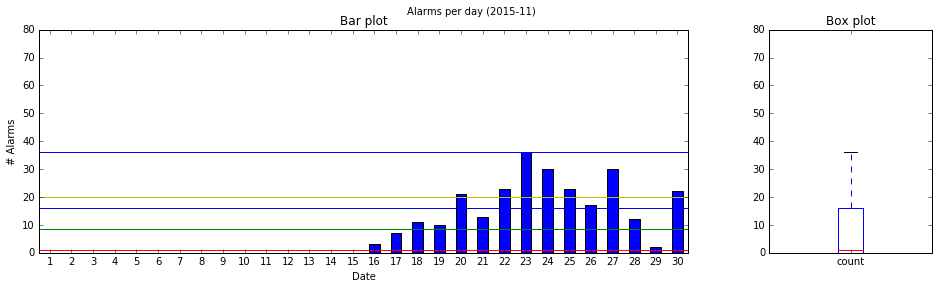

2015-12
-------
Range:  57.00
IQR:    19.50
var:    236.88
std:    15.39


2016-01
-------
Range:  83.00
IQR:    13.00
var:    443.18
std:    21.05


2016-02
-------
Range:  71.00
IQR:    10.00
var:    186.84
std:    13.67


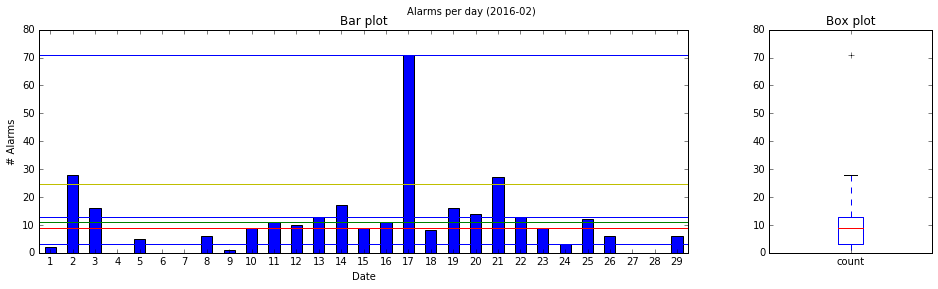

2016-03
-------
Range:  54.00
IQR:    3.50
var:    130.77
std:    11.44


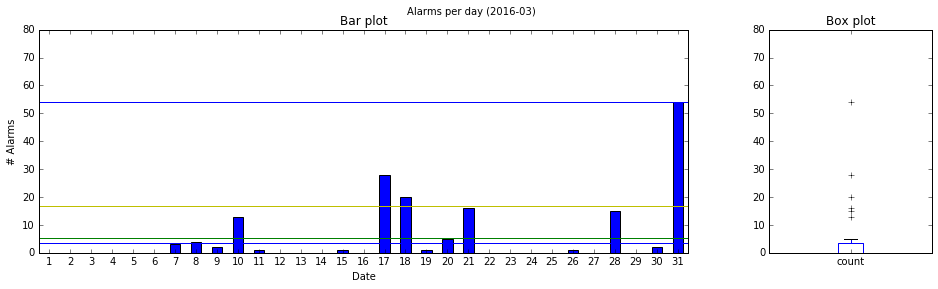

2016-04
-------
Range:  41.00
IQR:    1.75
var:    66.10
std:    8.13


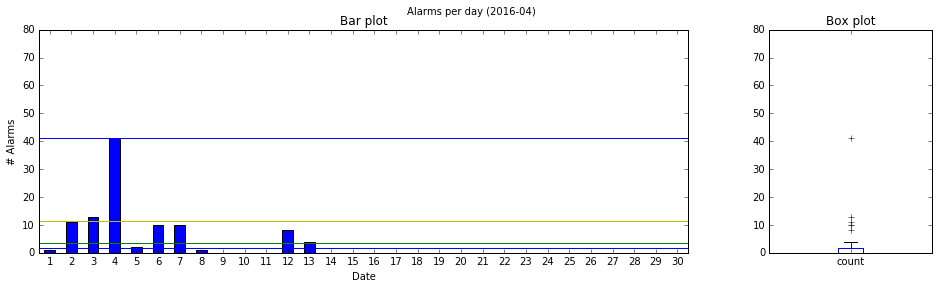

In [33]:
PlotMoS(cts_select)